In [374]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import scipy.signal as sp_sig
import scipy.fft as sp_fft
from te import transfer_entropy
from cjte import calculate_cjte
import re

In [375]:
def calculate_fundamental_component(
    signal: np.array, fs: float, low_f=0.66, high_f=3
) -> tuple[float, float]:
    """
    Calculates fundamental component of signal in given frequency range
    :param signal: signal
    :param fs: sampling frequency
    :param low_f: lower frequency range
    :param high_f: higher frequency range
    :return: fundamental frequency and its amplitude
    """
    n_fft = len(signal)
    win_fft_amp = sp_fft.rfft(
        sp_sig.detrend(signal) * sp_sig.windows.hann(n_fft), n=n_fft
    )
    corr_factor = n_fft / np.sum(sp_sig.windows.hann(n_fft))
    win_fft_amp = abs(win_fft_amp) * 2 / n_fft * corr_factor

    win_fft_f = sp_fft.rfftfreq(n_fft, d=1 / fs)
    f_low = int(low_f * n_fft / fs)
    f_upp = int(high_f * n_fft / fs)
    win_fft_amp_range = win_fft_amp[f_low:f_upp]
    fund_idx = np.argmax(win_fft_amp_range) + f_low

    fund_f = win_fft_f[fund_idx]
    fund_amp = win_fft_amp[fund_idx]
    return fund_f, fund_amp

def calculate_mean_HR(signal: np.array, fs: float = 200) -> float:
    """
    Calculates mean HR from abp signal
    :param signal: abp signal
    :param fs: sampling frequency
    """
    c_f1, amp_abp = calculate_fundamental_component(signal, fs)
    HR = c_f1 * 60
    return HR

In [376]:
def find_peaks(
    signal: np.array,
    sampling_rate: int = 200,
    mindelay: float = 0.3,
) -> np.array:    
    # Fill missing values
    filled_signal = nk.signal_fillmissing(signal)
    cleaned_signal = nk.ppg_clean(filled_signal, sampling_rate=sampling_rate, method="elgendi")
    peaks_up = nk.ppg_findpeaks(
        cleaned_signal, sampling_rate=sampling_rate, method="elgendi", mindelay=mindelay
    )['PPG_Peaks']
    peaks_down = nk.ppg_findpeaks(
        cleaned_signal * -1, sampling_rate=sampling_rate, method="elgendi", mindelay=mindelay
    )['PPG_Peaks']
    return peaks_up, peaks_down

In [377]:
def get_hp(peaks: np.array, sampling_rate: int = 200):
    rr = np.diff(peaks) / sampling_rate
    hp = 1 / rr
    return hp

def get_sap(signal, peaks):
    sap = np.array([signal[peak] for peak in peaks])[1:] # skip first peak to match length of hp
    return sap

def get_map(signal, peaks_up, peaks_down):
    peaks = np.sort(np.concatenate((peaks_up, peaks_down)))
    first_peak = 0 if peaks[0] < peaks[1] else 1

    # MAP = (2*DP + SP) / 3
    map_ = []
    for i in range(first_peak, len(peaks)-2, 2):
        dp = signal[peaks[i]]
        sp = signal[peaks[i+1]]
        map_.append((2*dp + sp) / 3)
    
    return np.array(map_)

def get_mcbfv(signal, peaks):
    mcbfv = np.array([np.mean(signal[peaks[i-1]:peaks[i]]) for i, _ in enumerate(peaks) if i > 0])
    return mcbfv

In [378]:
def read_fv(location):
    possible_fv_names = ['fvl', 'fvr']
    fvl = pd.read_csv(location, sep=';', decimal=',')['fvl'].values
    fvr = pd.read_csv(location, sep=';', decimal=',')['fvr'].values
    fvl_mean = np.mean(fvl)
    fvr_mean = np.mean(fvr)

    if fvl_mean > 30:
        return fvl
    elif fvr_mean > 30:
        return fvr
    else:
        return None

In [379]:
def plot_signals(signals):
    fig, axs = plt.subplots(5, 1, figsize=(20, 10))
    for i, (key, value) in enumerate(signals.items()):
        axs[i].plot(value)
        axs[i].set_title(key)
    plt.show()

In [380]:
def get_signals(file_location, sampling_rate: int = 200, mindelay: float = 0.3):
    signals = {}
    abp = pd.read_csv(file_location, sep=';', decimal=',')['abp_cnap[mmHg]'].values
    fv = read_fv(file_location)
    if fv is None:
        print('No FV signal found')
        return None
        
    abp_peaks_up, abp_peaks_down = find_peaks(abp, sampling_rate, mindelay)
    fv_peaks_up, fv_peaks_down = find_peaks(fv, sampling_rate, mindelay)

    signals['ABP_mean'] = np.mean(abp)
    signals['FV_mean'] = np.mean(fv)
    signals['HR_mean'] = calculate_mean_HR(abp, sampling_rate)
    signals['ETCO2_mean'] = np.mean(pd.read_csv(file_location, sep=';', decimal=',')['etco2[mmHg]'].values)
    signals['HP'] = get_hp(abp_peaks_up)
    signals['SAP'] = get_sap(abp, abp_peaks_up)
    signals['MAP'] = get_map(abp, abp_peaks_up, abp_peaks_down)
    signals['MCBFV'] = get_mcbfv(fv, fv_peaks_down)
    signals['R'] = pd.read_csv(file_location, sep=';', decimal=',')['rr[rpm]'].values
    if any(np.isnan(signals['R'])):
        print('R signal contains NaN values')
        return None
    return signals

In [381]:
def calculate_te(signals):
    te = {}
    te['SAP->HP'] = transfer_entropy(signals["HP"], signals["SAP"])
    te['HP->SAP'] = transfer_entropy(signals["SAP"], signals["HP"])
    # adjust lenght of MAP and MCBFV
    min_len = min(len(signals["MAP"]), len(signals["MCBFV"]))
    signals["MAP"] = signals["MAP"][:min_len]
    signals["MCBFV"] = signals["MCBFV"][:min_len]
    te['MAP->MCBFV'] = transfer_entropy(signals["MCBFV"], signals["MAP"])
    te['MCBFV->MAP'] = transfer_entropy(signals["MAP"], signals["MCBFV"])
    return te

In [382]:
def conditional_joint_transfer_entropy(signals, reference_r):
    cjte = {}
    # normalise R
    normalised_r = signals["R"] / reference_r
    r_widnowed = np.array_split(normalised_r, len(signals["HP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['SAP->HP'] = calculate_cjte(signals["HP"], signals["SAP"], signalsr_matched)
    cjte['HP->SAP'] = calculate_cjte(signals["SAP"], signals["HP"], signalsr_matched)

    min_len = min(len(signals["MAP"]), len(signals["MCBFV"]))
    signals["MAP"] = signals["MAP"][:min_len]
    signals["MCBFV"] = signals["MCBFV"][:min_len]
    r_widnowed = np.array_split(normalised_r, len(signals["MAP"]))
    signalsr_matched = np.array([np.mean(window) for window in r_widnowed])
    cjte['MAP->MCBFV'] = calculate_cjte(signals["MCBFV"], signals["MAP"], signalsr_matched)
    cjte['MCBFV->MAP'] = calculate_cjte(signals["MAP"], signals["MCBFV"], signalsr_matched)
    return cjte

In [383]:
class Result:
    def __init__(self, id, abp, fv, hr, etco2, r, map, sap, mcbfv, hp, te, cjte):
        self.id = id
        self.abp = abp
        self.fv = fv
        self.hr = hr
        self.etco2 = etco2
        self.r = r
        self.map = map
        self.sap = sap
        self.mcbfv = mcbfv
        self.hp = hp
        self.te_hp_on_sap = te['HP->SAP']
        self.te_sap_on_hp = te['SAP->HP']
        self.te_mfv_on_map = te['MCBFV->MAP']
        self.te_map_on_mfv = te['MAP->MCBFV']
        self.cjte_hp_on_sap = cjte['HP->SAP']
        self.cjte_sap_on_hp = cjte['SAP->HP']
        self.cjte_mfv_on_map = cjte['MCBFV->MAP']
        self.cjte_map_on_mfv = cjte['MAP->MCBFV']

In [384]:
valid_datasets = [i for i in range(1, 38) if i not in [3, 4, 7, 14, 15, 10, 11, 17, 20, 24, 27, 28, 35]]

location_baseline = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_BASELINE/OCH_{on}_CLEAN_CB_BASELINE.csv'
location_6 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_6_BREATHS/OCH_{on}_CLEAN_CB_6.csv'
location_10 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_10_BREATHS/OCH_{on}_CLEAN_CB_10.csv'
location_15 = lambda on: f'data/CONTROL_BREATHING_RECORDINGS/OCHOTNIK_{on}/CLEAN_DATA_15_BREATHS/OCH_{on}_CLEAN_CB_15.csv'

In [385]:
results_baseline= []
results_6breaths = []
results_10breaths = []
results_15breaths = []
for res_g, loc in zip([results_baseline, results_6breaths, results_10breaths, results_15breaths],[location_baseline, location_6, location_10, location_15]):
    for on in valid_datasets:
        location = loc(on)
        referene_r = np.mean(pd.read_csv(location_baseline(on), sep=';', decimal=',')['rr[rpm]'].values)
        signals = get_signals(location)
        if signals is None or referene_r is None:
            print(f'Error in dataset {on}')
            continue
        te_results = calculate_te(signals)
        cjte_results = conditional_joint_transfer_entropy(signals, referene_r)
        result = Result(
            on,
            signals['ABP_mean'], 
            signals['FV_mean'],
            signals['HR_mean'],
            signals['ETCO2_mean'],
            np.mean(signals['R']),
            np.mean(signals['MAP']),
            np.mean(signals['SAP']),
            np.mean(signals['MCBFV']),
            np.mean(signals['HP']),
            te_results,
            cjte_results
        )
        res_g.append(result)

In [386]:
# Save results to csv for each breathing type
df_baseline = pd.DataFrame([vars(res) for res in results_baseline])
df_baseline.to_csv('results_baseline.csv', index=False)
df_6breaths = pd.DataFrame([vars(res) for res in results_6breaths])
df_6breaths.to_csv('results_6breaths.csv', index=False)
df_10breaths = pd.DataFrame([vars(res) for res in results_10breaths])
df_10breaths.to_csv('results_10breaths.csv', index=False)
df_15breaths = pd.DataFrame([vars(res) for res in results_15breaths])
df_15breaths.to_csv('results_15breaths.csv', index=False)

In [388]:
def plot_boxplots(df_baseline, df_6breaths, df_10breaths, df_15breaths):    
    for type in ['te', 'cjte']:
        # Create paired subplots for HP->SAP and SAP->HP
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        for i, col in enumerate(['_hp_on_sap', '_sap_on_hp']):
            data = [df_baseline[type+col].values,
                    df_6breaths[type+col].values,
                    df_10breaths[type+col].values,
                    df_15breaths[type+col].values]
            axes[i].boxplot(data)
            axes[i].set_xticklabels(['Baseline', '6 breaths', '10 breaths', '15 breaths'])
            axes[i].set_title(type.capitalize() + ' ' + (['HP->SAP', 'SAP->HP'][i]))
        plt.tight_layout()
        plt.show()

        # Create paired subplots for MCBFV->MAP and MAP->MCBFV
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        for i, col in enumerate(['_mfv_on_map', '_map_on_mfv']):
            data = [df_baseline[type+col].values,
                    df_6breaths[type+col].values,
                    df_10breaths[type+col].values,
                    df_15breaths[type+col].values]
            axes[i].boxplot(data)
            axes[i].set_xticklabels(['Baseline', '6 breaths', '10 breaths', '15 breaths'])
            axes[i].set_title(type.capitalize() + ' ' + (['MCBFV->MAP', 'MAP->MCBFV'][i]))
        plt.tight_layout()
        plt.show()

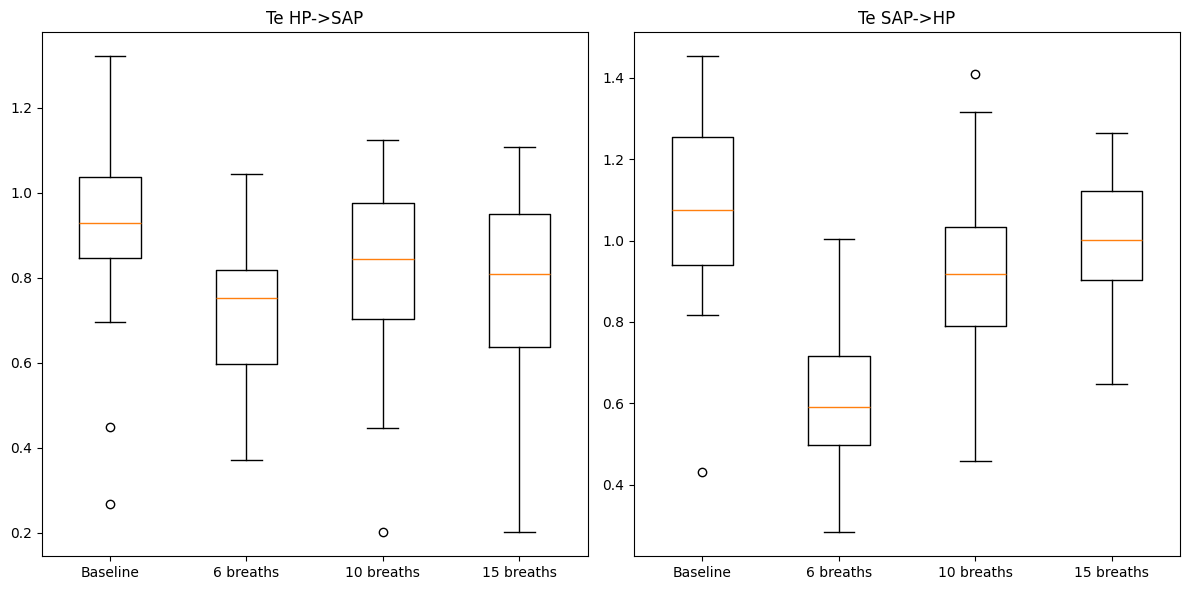

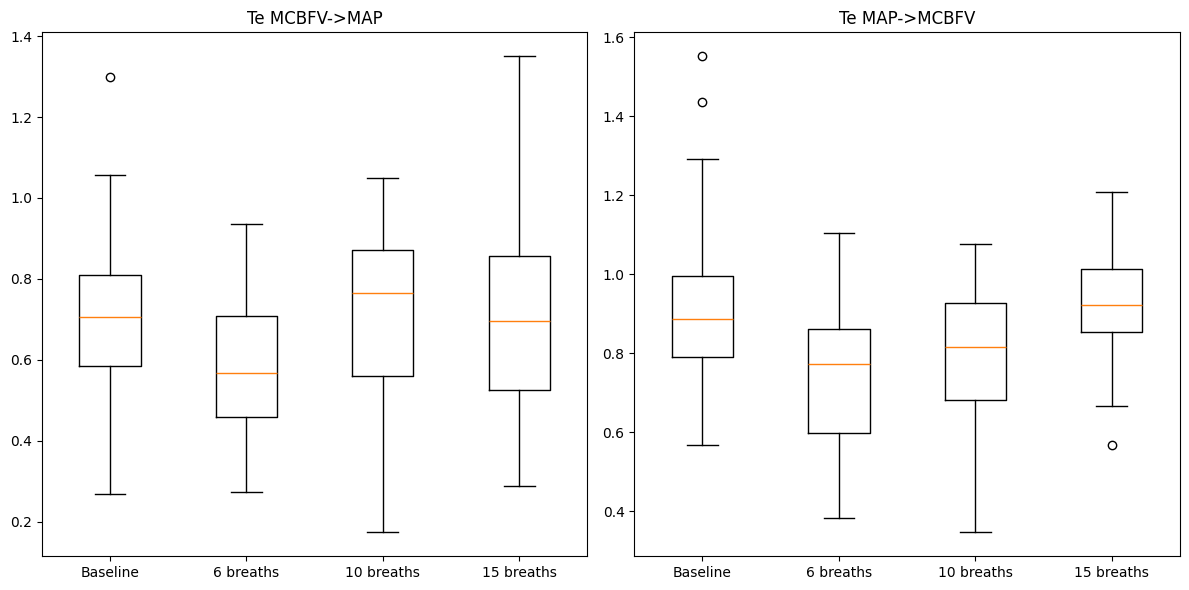

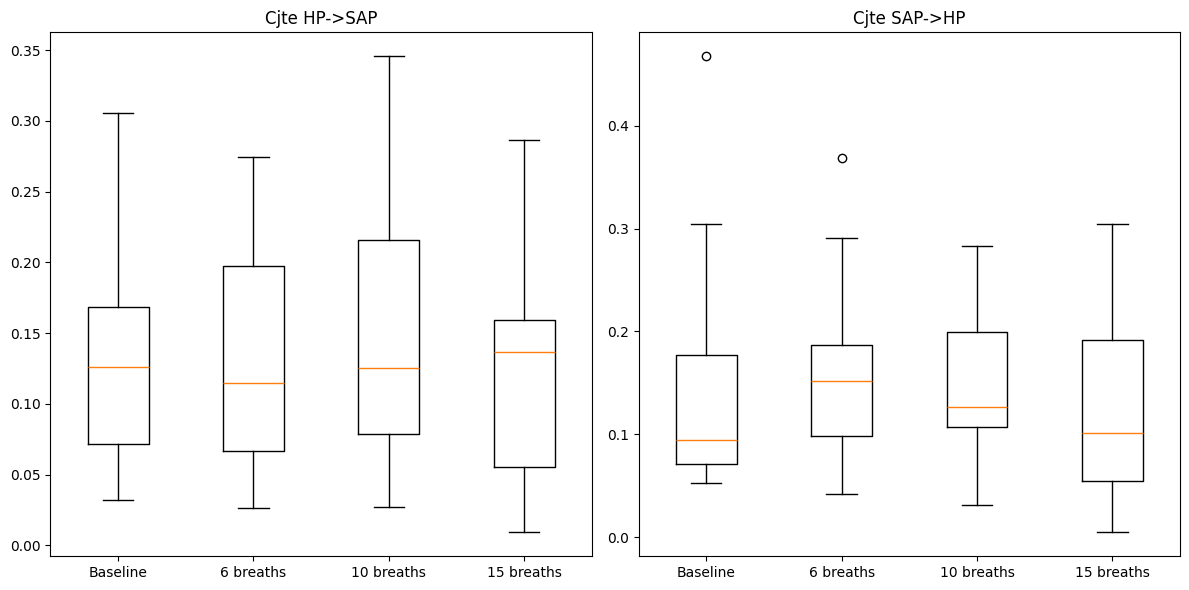

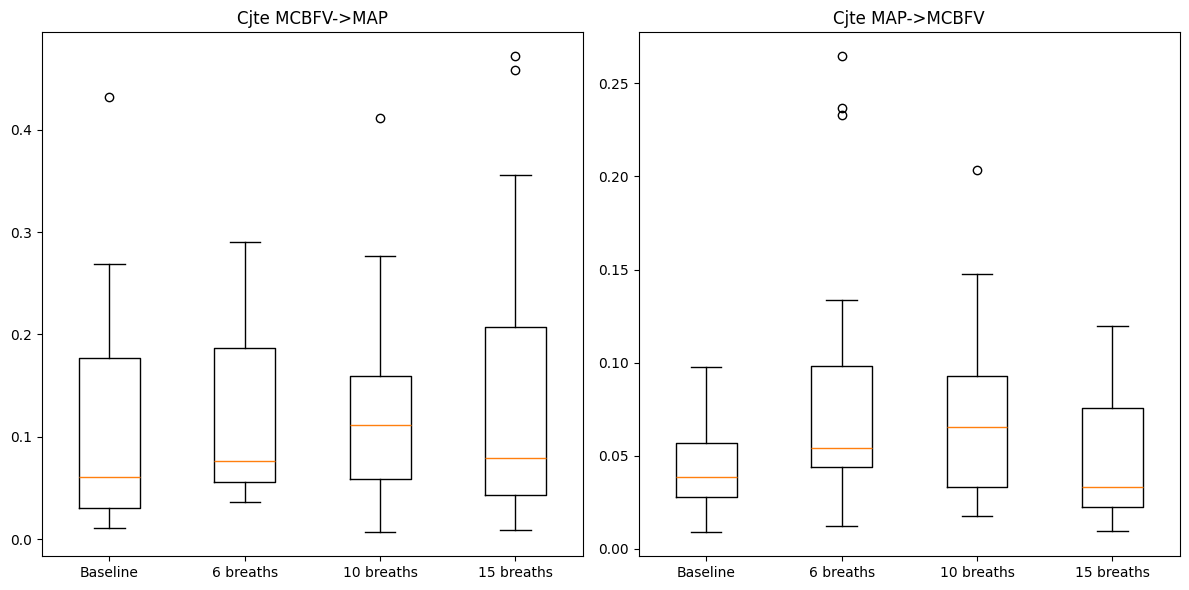

In [389]:
plot_boxplots(df_baseline, df_6breaths, df_10breaths, df_15breaths)

# Lets divide patients into two groups: those with mean baseline breathing rate above 15 and below 15.

In [391]:
# get id of patients with r < 15
low_r = df_baseline[df_baseline['r'] < 15]['id'].values
high_r = df_baseline[df_baseline['r'] > 15]['id'].values

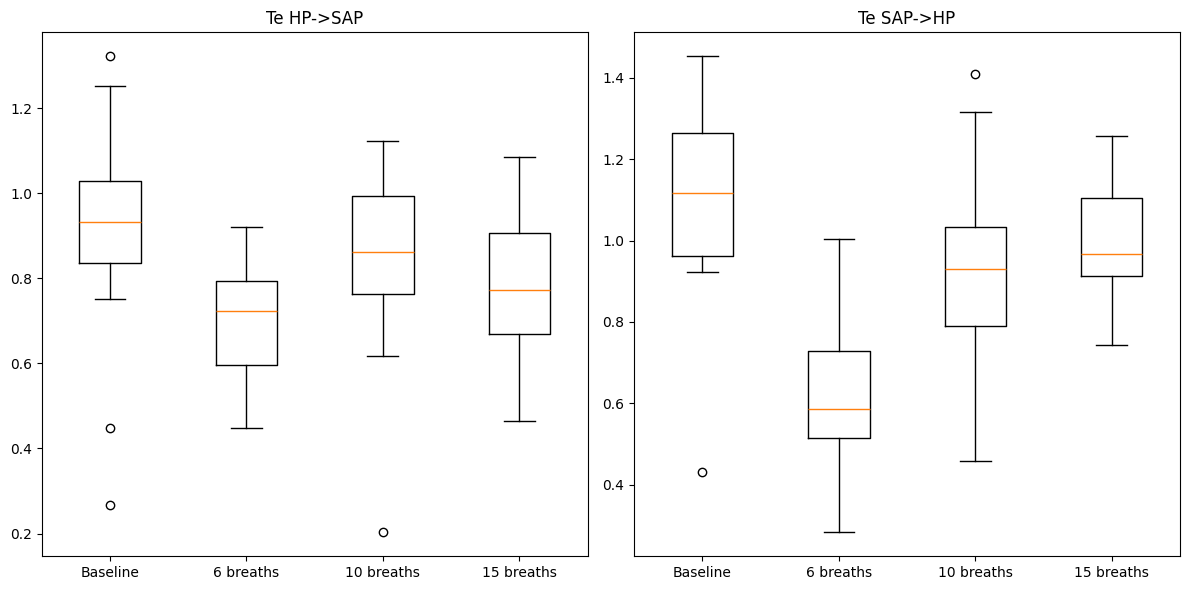

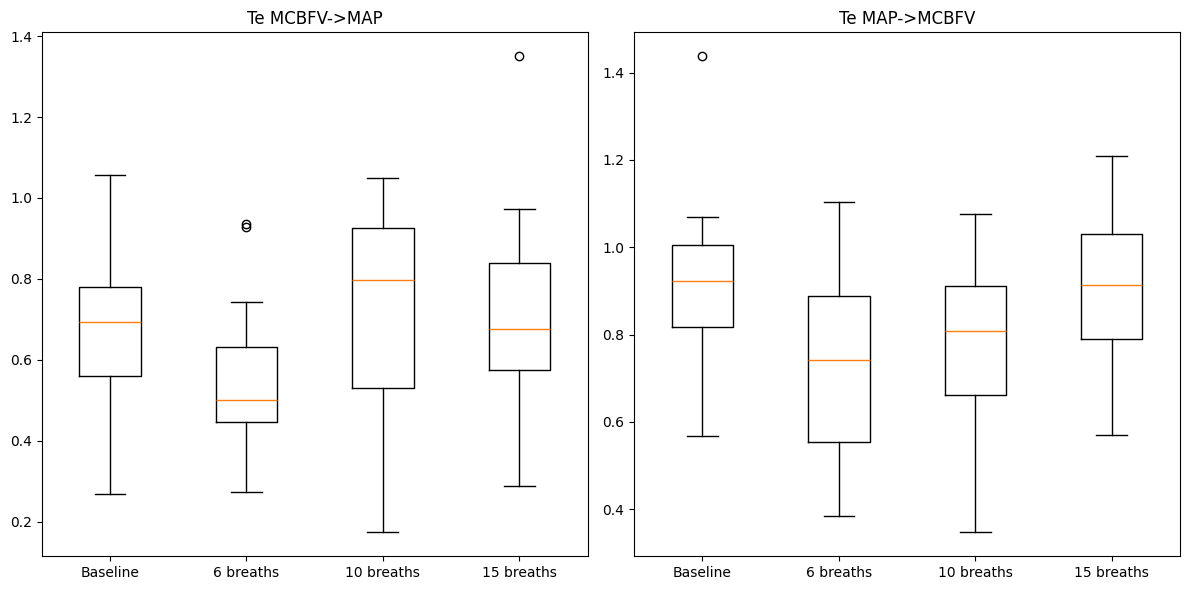

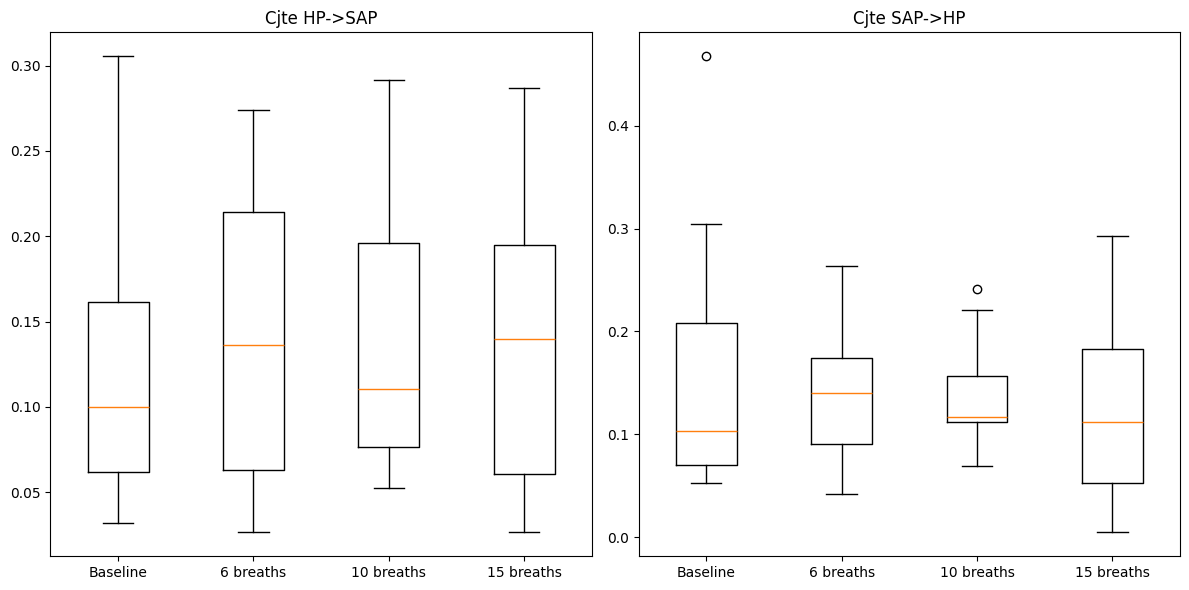

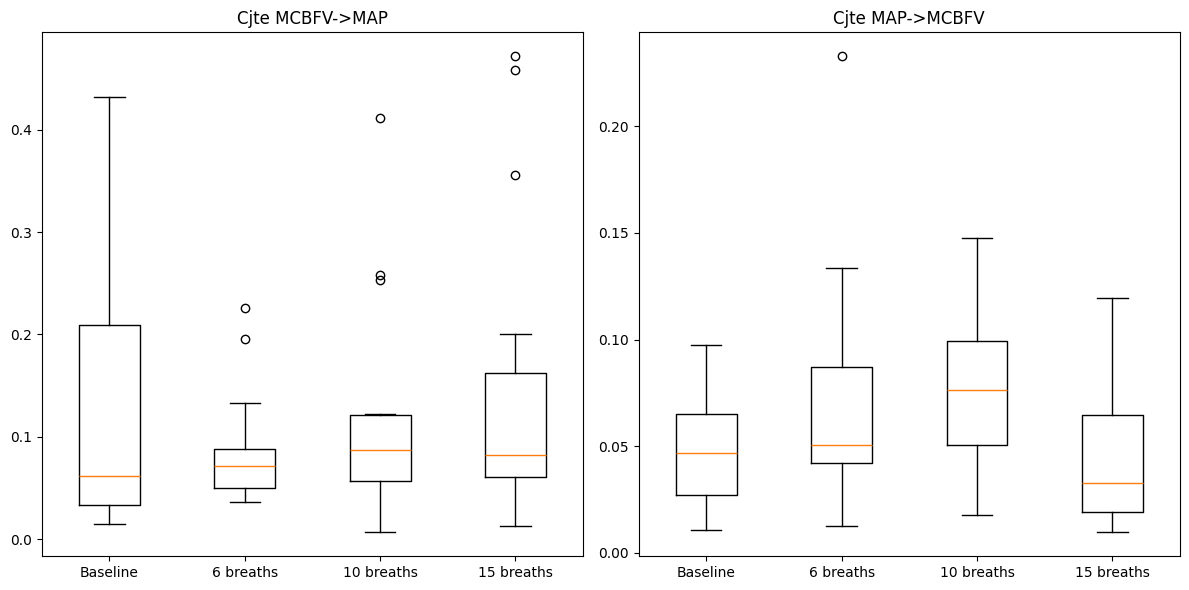

In [392]:
# use only patients with r > 15
plot_boxplots(df_baseline[df_baseline['id'].isin(high_r)], df_6breaths[df_6breaths['id'].isin(high_r)], df_10breaths[df_10breaths['id'].isin(high_r)], df_15breaths[df_15breaths['id'].isin(high_r)])

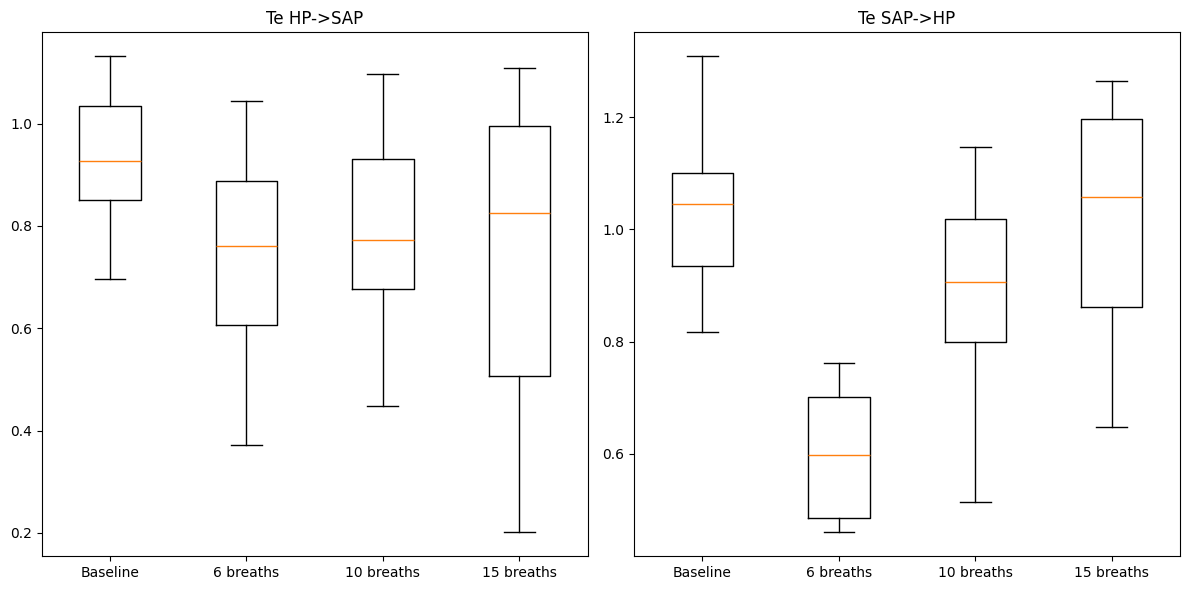

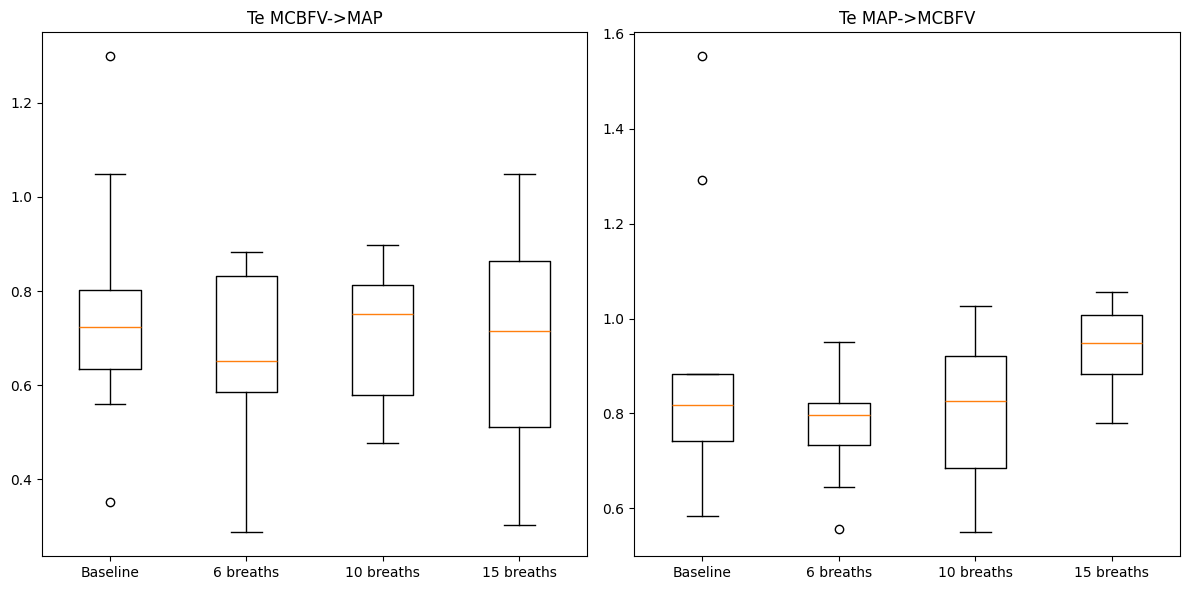

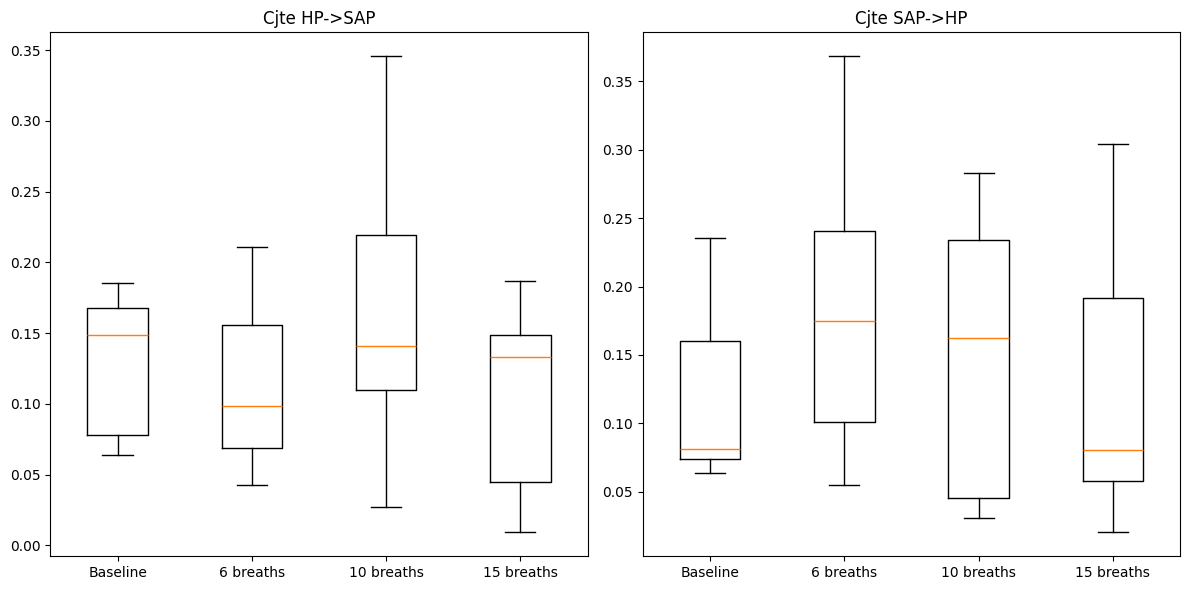

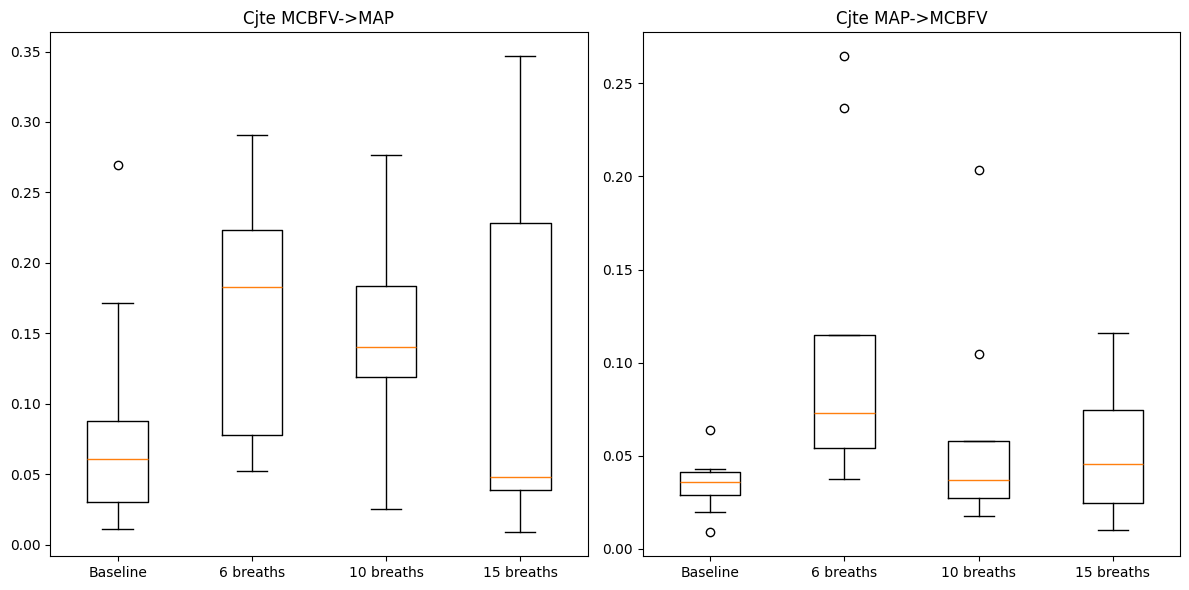

In [393]:
# use only patients with r < 15
plot_boxplots(df_baseline[df_baseline['id'].isin(low_r)], df_6breaths[df_6breaths['id'].isin(low_r)], df_10breaths[df_10breaths['id'].isin(low_r)], df_15breaths[df_15breaths['id'].isin(low_r)])